In [1]:
import os
import re
import numpy as np
import pandas as pd
import pickle as pkl
from metallum import Band, Album, Song

import nltk
from nltk.corpus import stopwords
languages = ['english', 'german', 'french', 'finnish', 'swedish', 'norwegian', 'danish', 'russian']
stop_words = set()
for language in languages:
    stop_words.update(set(stopwords.words(language)))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, confusion_matrix
from sklearn.pipeline import make_pipeline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

from imblearn.over_sampling import RandomOverSampler, SMOTE

Using TensorFlow backend.


# Preprocessing
## Combine song lyrics with genres

In [2]:
LYRICS_DIR = 'lyrics/'
BANDS_DIR = 'bands/'

In [3]:
band_filenames = [f for f in os.listdir(BANDS_DIR) if '.pkl' in f]
bands = [pkl.load(open(os.path.join(BANDS_DIR, f), 'rb')) for f in band_filenames]
band_genres = {b.name.lower(): b.genres for b in bands}

In [4]:
lyrics_filenames = [f for f in os.listdir(LYRICS_DIR) if '.pkl' in f]
lyrics = {filename.replace('.pkl', ''): pkl.load(open(os.path.join(LYRICS_DIR, filename), 'rb')) for filename in lyrics_filenames}
corpus = []
band_names = []
song_names = []
vocabulary = set()
genres = []
for band, band_lyrics in lyrics.items():
    if band in band_genres.keys():
        for album, album_lyrics in band_lyrics.items():
            for song, song_lyrics in album_lyrics.items():
                words = []
                for line in song_lyrics:
                    for w in line.split():
                        s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", w.lower())
                        if s:
                            w = s.group()
                            if w not in stop_words:
                                words.append(w)
                song_name = []
                for w in song.split():
                    s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", re.sub('\d+\.', '', w).lower())
                    if s:
                        song_name.append(s.group())
                song_name = ' '.join(song_name)
                document = ' '.join(words)
                if len(document) > 0:
                    corpus.append(document)
                    band_names.append(band)
                    song_names.append(song_name)
                    vocabulary.update(set(words))
                    genres.append(band_genres[band])
print("vocabulary size: {}".format(len(vocabulary)))

vocabulary size: 170516


### Full lyrics + genres dataframe

In [5]:
df_rows = [
    {'band': band_names[i], 'song': song_names[i], 'lyrics': corpus[i], 'genres': genres[i]} for i in range(len(corpus))
]
df = pd.DataFrame(df_rows, columns=['band', 'song', 'lyrics', 'genres'])
df = df.drop_duplicates(subset=['band', 'song'])
print(df.shape)
df.head()

(42460, 4)


,band,song,lyrics,genres
0,defiance,the fault,danger lingers air tonight feel right somethin...,[thrash]
1,defiance,death machine,take look future see time exist seem find real...,[thrash]
2,defiance,product of society,lost mind looking something fill empty space g...,[thrash]
3,defiance,forgotten,forgotten fought shit went hell lived pain lea...,[thrash]
4,defiance,lock jaw,ever felt puncture thru skin piece metal rusty...,[thrash]


### Statistics of song word counts

In [6]:
song_lengths = df['lyrics'].apply(lambda x: len(x.split()))
print(round(song_lengths.mean()), round(song_lengths.std()), song_lengths.min(), song_lengths.max())

84 44 1 966


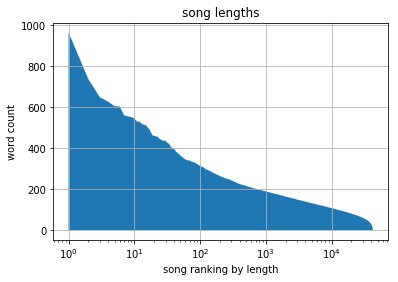

In [7]:
plt.fill_between(range(1, df.shape[0] + 1), 0, song_lengths.sort_values()[::-1].reset_index(drop=True))
plt.title("song lengths")
plt.xlabel('song ranking by length')
plt.ylabel('word count')
plt.xscale('log')
plt.grid(axis='both')
plt.show()

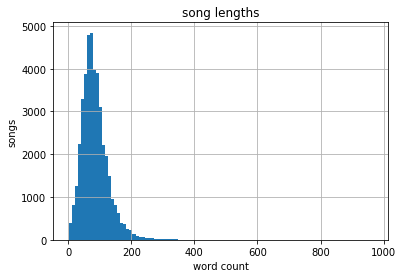

In [8]:
song_lengths.hist(bins=100)
plt.title("song lengths")
plt.xlabel('word count')
plt.ylabel('songs')
plt.show()

### Genres dataframe

In [23]:
unique_genres = []
for lst in df['genres'].tolist():
    for x in lst:
        if (x not in stop_words) and (not re.match('\-.*', x)) and (x not in unique_genres):
            unique_genres.append(x)
unique_genres.sort()

df_genres_full = pd.DataFrame(index=df.index, columns=unique_genres)
for genre in unique_genres:
    df_genres_full[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
df_genres_full['band'] = df['band'].copy()
df_genres_bands = df_genres_full.groupby('band').max()
df_genres_full.drop('band', axis=1, inplace=True)
top_genres = df_genres_full.columns[df_genres_full.mean(axis=0) > 0.1]

genre_associations = {}
for genre in unique_genres:
    if genre not in top_genres:
        series = df_genres_bands[df_genres_bands[genre] == 1].sum(axis=0).sort_values(ascending=False)
        nearest_top_genre = series[series.index.isin(top_genres)]
        if nearest_top_genre.iloc[0] > 5 and nearest_top_genre.iloc[0] > 0.5 * series.iloc[0]:
            print(genre, nearest_top_genre.index[0], nearest_top_genre.iloc[0], series.iloc[0])
            genre_associations[genre] = nearest_top_genre.index[0]
            col = df_genres_full[nearest_top_genre.index[0]].copy()
            col[df_genres_full[genre] == 1] = 1
            df_genres_full[nearest_top_genre.index[0]] = col

top_genres = df_genres_full.columns[df_genres_full.mean(axis=0) > 0.1]
df_genres = df_genres_full[top_genres].copy()
df_genres['other'] = (df_genres.sum(axis=1) == 0).astype(int)
# df_genres.head()

ambient black 9 13
atmospheric black 8 11
brutal death 26 27
depressive black 6 7
experimental black 9 14
grindcore death 12 17
hard heavy 8 11
nwobhm heavy 6 10
pagan black 11 12
speed thrash 19 36
technical death 31 40
viking black 12 16


,black,death,heavy,melodic,power,progressive,thrash,other
0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0


In [25]:
df_genres.mean(axis=0).sort_values(ascending=False)

death          0.351578
black          0.254451
thrash         0.232407
heavy          0.171244
power          0.164225
progressive    0.110551
melodic        0.106877
other          0.100141
dtype: float64

## Tokenization & oversampling

### Train-test split lyrics and single genre label

In [26]:
corpus_train, corpus_test, y_train, y_test = train_test_split(df['lyrics'].values, df_genres['power'].values, test_size=0.2)

### Transform corpuses with vectorizer fit to training corpus

In [27]:
vectorizer = CountVectorizer()
vectorizer.fit(corpus_train)
X_train = vectorizer.transform(corpus_train)
X_test = vectorizer.transform(corpus_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33968, 146416) (8492, 146416) (33968,) (8492,)


### Feature reduction

In [28]:
class FeatureReducer:
    def __init__(self, thresh=0):
        self.thresh = thresh

    def fit(self, X):
        self.features = np.arange(X.shape[1])
        self.features_reduced = self.features[np.array(X.mean(axis=0) > self.thresh * X.mean()).flatten()]

    def reduce(self, *args):
        out = ()
        for X in args:
            out += (X[:, self.features_reduced],)
        return out

feature_reducer = FeatureReducer(0)

### Oversample training data

In [29]:
oversampler = RandomOverSampler(random_state=0)

# Prototyping

In [30]:
from sklearn.model_selection import StratifiedKFold

## Random forest classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf_params = {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))
for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
    feature_reducer.fit(X_fold_train)
    X_fold_train, X_fold_valid = feature_reducer.reduce(X_fold_train, X_fold_valid)
    X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)
    model = RandomForestClassifier(n_jobs=-1, random_state=0, **rf_params)
    model.fit(X_fold_train, y_fold_train)
    y_fold_pred = model.predict(X_fold_valid)
    scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[i] = confusion_matrix(y_fold_valid, y_fold_pred)
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

CV score: 70.61% +/- 0.76%
Average confusion matrix:
[[0.71499647 0.12096679]
 [0.07268606 0.09135068]]


In [33]:
# feature_reducer.fit(X_train)
# X_train_reduced, X_test_reduced = feature_reducer.reduce(X_train, X_test)

# rf_model = RandomForestClassifier(n_jobs=-1, random_state=0, **rf_params)
# rf_model.fit(*oversampler.fit_resample(X_train_reduced, y_train))

# y_pred = rf_model.predict(X_test_reduced)
# y_prob = rf_model.predict_proba(X_test_reduced)[:, 1]
# print("Score: {:.2f}%".format(100 * balanced_accuracy_score(y_test, y_pred)))
# print(confusion_matrix(y_test, y_pred))

# plt.figure(figsize=(16, 4))
# bins = np.linspace(0, 1, 21)
# xticks = np.linspace(0, 1, 11)
# plt.hist(y_prob[y_test == 1], bins=bins, edgecolor='k', alpha=0.5, label='y_true = 1')
# plt.hist(y_prob[y_test == 0], bins=bins, edgecolor='k', alpha=0.5, label='y_true = 0')
# plt.xlim(0, 1)
# plt.xticks(xticks)
# plt.grid(alpha=0.5)
# plt.legend()
# plt.show()

## Logistic regression

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))
for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
    feature_reducer.fit(X_fold_train)
    X_fold_train, X_fold_valid = feature_reducer.reduce(X_fold_train, X_fold_valid)
    X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)
    model = LogisticRegression(random_state=0)
    model.fit(X_fold_train, y_fold_train)
    y_fold_pred = model.predict(X_fold_valid)
    scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[i] = confusion_matrix(y_fold_valid, y_fold_pred)
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CV score: 69.25% +/- 1.95%
Average confusion matrix:
[[0.72270961 0.11325365]
 [0.07866227 0.08537447]]


In [36]:
# feature_reducer.fit(X_train)
# X_train_reduced, X_test_reduced = feature_reducer.reduce(X_train, X_test)

# lr_model = LogisticRegression(random_state=0)
# lr_model.fit(*oversampler.fit_resample(X_train_reduced, y_train))

# y_pred = lr_model.predict(X_test_reduced)
# y_prob = lr_model.predict_proba(X_test_reduced)[:, 1]
# print("Score: {:.2f}%".format(100 * balanced_accuracy_score(y_test, y_pred)))
# print(confusion_matrix(y_test, y_pred))

# plt.figure(figsize=(16, 4))
# bins = np.linspace(0, 1, 21)
# xticks = np.linspace(0, 1, 11)
# plt.hist(y_prob[y_test == 1], bins=bins, edgecolor='k', alpha=0.5, label='y_true = 1')
# plt.hist(y_prob[y_test == 0], bins=bins, edgecolor='k', alpha=0.5, label='y_true = 0')
# plt.xlim(0, 1)
# plt.xticks(xticks)
# plt.grid(alpha=0.5)
# plt.legend()
# plt.show()

## Stacked model

In [37]:
from mlxtend.classifier import StackingClassifier

In [38]:
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))
for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
    feature_reducer.fit(X_fold_train)
    X_fold_train, X_fold_valid = feature_reducer.reduce(X_fold_train, X_fold_valid)
    X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)
    rf_params = {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
    rf_model = RandomForestClassifier(n_jobs=-1, random_state=0, **rf_params)
    lr_model = LogisticRegression(random_state=0)
    model = StackingClassifier([rf_model], lr_model, use_probas=True)
    model.fit(X_fold_train, y_fold_train)
    y_fold_pred = model.predict(X_fold_valid)
    scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[i] = confusion_matrix(y_fold_valid, y_fold_pred)
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

CV score: 71.48% +/- 1.23%
Average confusion matrix:
[[0.68773552 0.14822774]
 [0.06447244 0.0995643 ]]


In [39]:
# feature_reducer.fit(X_train)
# X_train_reduced, X_test_reduced = feature_reducer.reduce(X_train, X_test)

# rf_params = {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# rf_model = RandomForestClassifier(n_jobs=-1, random_state=0, **rf_params)
# lr_model = LogisticRegression(random_state=0)
# stacked_model = StackingClassifier([rf_model], lr_model, use_probas=True)
# stacked_model.fit(*oversampler.fit_resample(X_train_reduced, y_train))

# y_pred = stacked_model.predict(X_test_reduced)
# y_prob = stacked_model.predict_proba(X_test_reduced)[:, 1]
# print("Score: {:.2f}%".format(100 * balanced_accuracy_score(y_test, y_pred)))
# print(confusion_matrix(y_test, y_pred))

# plt.figure(figsize=(16, 4))
# bins = np.linspace(0, 1, 21)
# xticks = np.linspace(0, 1, 11)
# plt.hist(y_prob[y_test == 1], bins=bins, edgecolor='k', alpha=0.5, label='y_true = 1')
# plt.hist(y_prob[y_test == 0], bins=bins, edgecolor='k', alpha=0.5, label='y_true = 0')
# plt.xlim(0, 1)
# plt.xticks(xticks)
# plt.grid(alpha=0.5)
# plt.legend()
# plt.show()

# Test with Keras model

In [40]:
def nn_model(input_dim):
    model = Sequential()
    model.add(layers.Dense(40, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model

def nn_batch_generator(X_data, y_data, batch_size):
    number_of_batches = X_data.shape[0] // batch_size
    counter = 0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X_data[index_batch, :].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch), y_batch
        if (counter > number_of_batches):
            counter = 0

In [79]:
epochs = 5
batch_size = 128
feature_reducer = FeatureReducer(0)
oversampler = SMOTE(random_state=0)

n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))
for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
    feature_reducer.fit(X_fold_train)
    X_fold_train, X_fold_valid = feature_reducer.reduce(X_fold_train, X_fold_valid)
    X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)
    keras_model = KerasClassifier(
        nn_model,
        input_dim=X_fold_train.shape[1],
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0)],
        validation_data=(X_fold_valid, y_fold_valid)
    )
    keras_model.fit(X_fold_train, y_fold_train)
    y_fold_pred = keras_model.predict(X_fold_valid)
    scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[i] = confusion_matrix(y_fold_valid, y_fold_pred)
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

Train on 45432 samples, validate on 6795 samples
Epoch 1/5
45432/45432 [==============================] - 79s 2ms/step - loss: 0.3988 - binary_accuracy: 0.8517 - val_loss: 0.4788 - val_binary_accuracy: 0.7860
Epoch 2/5
45432/45432 [==============================] - 77s 2ms/step - loss: 0.2009 - binary_accuracy: 0.9236 - val_loss: 0.5394 - val_binary_accuracy: 0.7957
Train on 45434 samples, validate on 6794 samples
Epoch 1/5
45434/45434 [==============================] - 83s 2ms/step - loss: 0.3947 - binary_accuracy: 0.8519 - val_loss: 0.4957 - val_binary_accuracy: 0.7960
Epoch 2/5
45434/45434 [==============================] - 79s 2ms/step - loss: 0.2017 - binary_accuracy: 0.9233 - val_loss: 0.5488 - val_binary_accuracy: 0.7933
Train on 45434 samples, validate on 6793 samples
Epoch 1/5
45434/45434 [==============================] - 80s 2ms/step - loss: 0.3930 - binary_accuracy: 0.8537 - val_loss: 0.4777 - val_binary_accuracy: 0.7992
Epoch 2/5
45434/45434 [==============================

## Stacking RF with NN

In [100]:
class StackedModel:
    def __init__(self, clfs=[], meta_clf=None):
        self.clfs = clfs
        self.meta_clf = meta_clf

    def fit(self, X, y, split_test_size=0.2):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size)
        y_prob = np.zeros((X_test.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            clf.fit(X_train, y_train)
            y_prob[:, j] = clf.predict_proba(X_test)[:, 1]
        self.meta_clf.fit(y_prob, y_test)

    def predict(self, X):
        y_prob = np.zeros((X.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            y_prob[:, j] = clf.predict_proba(X)[:, 1]
        y_pred = self.meta_clf.predict(y_prob)
        return y_pred

In [104]:
feature_reducer = FeatureReducer(1)
oversampler = RandomOverSampler(random_state=0)
nn_params = {'epochs': 1, 'batch_size': 128}
rf_params = {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))

for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
    feature_reducer.fit(X_fold_train)
    X_fold_train, X_fold_valid = feature_reducer.reduce(X_fold_train, X_fold_valid)
    X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)

    rf_model = RandomForestClassifier(n_jobs=-1, random_state=0, **rf_params)
    keras_model = KerasClassifier(nn_model, input_dim=X_fold_train.shape[1], **nn_params)
    lr_model = LogisticRegression(random_state=0)
    clfs = [rf_model, keras_model]
    meta_clf = lr_model

    stacked_model = StackedModel([rf_model, keras_model], lr_model)
    stacked_model.fit(X_fold_train, y_fold_train)
    y_fold_pred = stacked_model.predict(X_fold_valid)

    scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[i] = confusion_matrix(y_fold_valid, y_fold_pred)

print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

Epoch 1/1
30288/30288 [==============================] - 6s 186us/step - loss: 0.4442 - binary_accuracy: 0.8018


/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
30289/30289 [==============================] - 6s 188us/step - loss: 0.4420 - binary_accuracy: 0.8037


/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
30289/30289 [==============================] - 6s 186us/step - loss: 0.4341 - binary_accuracy: 0.8067


/home/philippe/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV score: 71.21% +/- 1.54%
Average confusion matrix:
[[0.75485751 0.08110575]
 [0.07854451 0.08549223]]


In [80]:
feature_reducer.fit(X_train)
X_train_reduced, X_test_reduced = feature_reducer.reduce(X_train, X_test)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_reduced, y_train)

rf_model = RandomForestClassifier(n_jobs=-1, random_state=0, **rf_params)
keras_model = KerasClassifier(nn_model, input_dim=X_train_resampled.shape[1], validation_data=(X_fold_valid, y_fold_valid), **nn_params)
lr_model = LogisticRegression(random_state=0)
clfs = [rf_model, keras_model]
meta_clf = lr_model

stacked_model = StackedModel([rf_model, keras_model], lr_model)
stacked_model.fit(X_fold_train, y_fold_train)
y_fold_pred = stacked_model.predict(X_fold_valid)

y_prob = keras_model.predict(X_test_reduced)
y_pred = y_prob.round()
print("Score: {:.2f}%".format(100 * balanced_accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(16, 4))
bins = np.linspace(0, 1, 21)
xticks = np.linspace(0, 1, 11)
plt.hist(y_prob[y_test == 1], bins=bins, edgecolor='k', alpha=0.5, label='y_true = 1')
plt.hist(y_prob[y_test == 0], bins=bins, edgecolor='k', alpha=0.5, label='y_true = 0')
plt.xlim(0, 1)
plt.xticks(xticks)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

Epoch 1/5
 3712/56792 [>.............................] - ETA: 1:44 - loss: 0.6103 - binary_accuracy: 0.6926

KeyboardInterrupt: 